In [1]:
import multimodal_cci as mmcci

2024-07-12 13:12:10.998113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 13:12:11.212179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-12 13:12:11.212222: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-12 13:12:12.627184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [3]:
import pickle

with open("/home/uqlhocke/MultimodalCCI/data/pancreas_whole.pkl", 'rb') as f:
    whole_pancreas = pickle.load(f)
    
with open("/home/uqlhocke/MultimodalCCI/data/pancreas_fovs.pkl", 'rb') as f:
    pancreas_fovs = pickle.load(f)

In [4]:
color_dict = {
    'Acinar.1': '#1f77b4',
    'Acinar.2': '#ff7f0e',
    'Active stellate': '#279e68',
    'Alpha cells': '#d62728',
    'Beta cells': '#aa40fc',
    'Delta cells': '#8c564b',
    'Ductal': '#e377c2',
    'Epsilon cells': '#b5bd61',
    'Gamma cells': '#17becf',
    'Macrophage': '#aec7e8',
    'Quiescent stellate': '#ffbb78',
    }

In [5]:
pancreas_data = {}

pancreas_data['cci'] = [pancreas_fovs[sample]['lr_scores'] for sample in range(len(pancreas_fovs))]
pancreas_data['pvals'] = [pancreas_fovs[sample]['lr_pvals'] for sample in range(len(pancreas_fovs))]
pancreas_data['sizes'] = [pancreas_fovs[sample]['n_spots'] for sample in range(len(pancreas_fovs))]

pancreas_data['cci'].append(whole_pancreas['lr_scores'])
pancreas_data['sizes'].append(whole_pancreas['n_spots'])

In [6]:
normalised = mmcci.it.normalise_within_tech(pancreas_data['cci'], pancreas_data['sizes'])

In [7]:
all = normalised[-1]
rest = normalised[:-1]

In [8]:
import copy

all_copy = copy.deepcopy(all)

all_filtered = mmcci.it.remove_insignificant(all_copy, whole_pancreas['lr_pvals'])

rest_filtered = []

rest_copy = copy.deepcopy(rest)

for i in range(len(rest)):
    rest_filtered.append(mmcci.it.remove_insignificant(rest_copy[i], pancreas_data['pvals'][i]))

In [9]:
integrated_pvals = mmcci.it.integrate_p_vals(pancreas_data['pvals'], method="fisher")

Integrating p values: 100%|██████████| 2134/2134 [02:54<00:00, 12.25it/s]


In [10]:
integrated_any_sum = mmcci.it.integrate_samples(copy.deepcopy(rest), method='any', sum=True)
integrated_any = mmcci.it.integrate_samples(copy.deepcopy(rest), method='any', sum=False)

Integrating LR matrices: 100%|██████████| 2134/2134 [01:37<00:00, 21.84it/s]


In [11]:
integrated_any_sum_filtered = mmcci.it.remove_insignificant(copy.deepcopy(integrated_any_sum), integrated_pvals)
integrated_any_filtered = mmcci.it.remove_insignificant(copy.deepcopy(integrated_any), integrated_pvals)

In [12]:
summed_fovs = {}

for sample in rest_filtered:
    for key in sample:
        if key not in summed_fovs:
            summed_fovs[key] = sample[key]
        else:
            summed_fovs[key], sample[key] = mmcci.tl.align_dataframes(summed_fovs[key], sample[key])
            summed_fovs[key] += sample[key]
            summed_fovs[key].fillna(0)

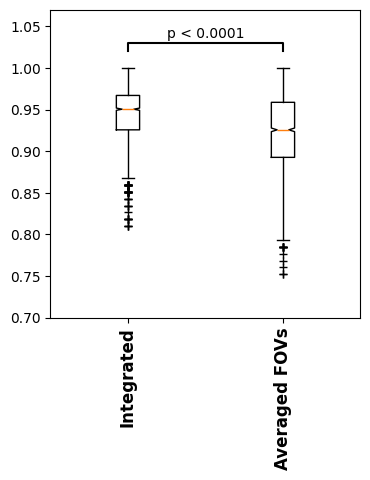

TtestResult(statistic=20.121535096795768, pvalue=2.6017597510188976e-86, df=4520.0)


In [14]:
from matplotlib import pyplot as plt
import pandas as pd

baseline = all_filtered

comparison = [integrated_any_sum_filtered, summed_fovs]

dissims = []

lrs = []
for sample in comparison:
    lrs += list(sample.keys())
lrs += list(baseline.keys())
lrs = list(set(lrs))

for sample in comparison:
    
    dissims_sample = []
    
    for lr in lrs:
        if lr not in sample.keys() or sample[lr].sum().sum() == 0:
            if lr not in baseline.keys() or baseline[lr].sum().sum() == 0:
                # dissims_sample.append(1)
                continue
            blank = pd.DataFrame(0, index=baseline[lr].index, columns=baseline[lr].columns)
            dissims_sample.append(1 - mmcci.sc.dissimilarity_score(blank, baseline[lr], lmbda=1, binary=True))
        elif lr not in baseline.keys() or baseline[lr].sum().sum() == 0:
            blank = pd.DataFrame(0, index=sample[lr].index, columns=sample[lr].columns)
            dissims_sample.append(1 - mmcci.sc.dissimilarity_score(sample[lr], blank, lmbda=1, binary=True))
        else:
            dissims_sample.append(1 - mmcci.sc.dissimilarity_score(sample[lr], baseline[lr], lmbda=1, binary=True))
            
    dissims.append(dissims_sample)

# plot a boxplot for each sample
plt.style.use('default')
plt.figure(figsize=(4, 4))
plt.boxplot(dissims, 1, 'k+')
plt.gca().set_xticklabels(["Integrated", "Averaged FOVs"], rotation=90, fontsize=12, fontweight='bold')

# set y limits
plt.ylim(0.7, 1.07)

x1, x2 = 1, 2
y, h, col = 1.02, 0.01, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.013, "p < 0.0001", ha='center', va='bottom', color=col)
plt.show()

import scipy.stats as stats

# print(stats.ttest_ind(dissims[0], [x for xs in dissims[1:] for x in xs]))

for dissim in dissims[1:]:
    print(stats.ttest_ind(dissims[0], dissim))

In [17]:
rest_overall = [mmcci.it.calculate_overall_interactions(sample) for sample in rest_filtered]

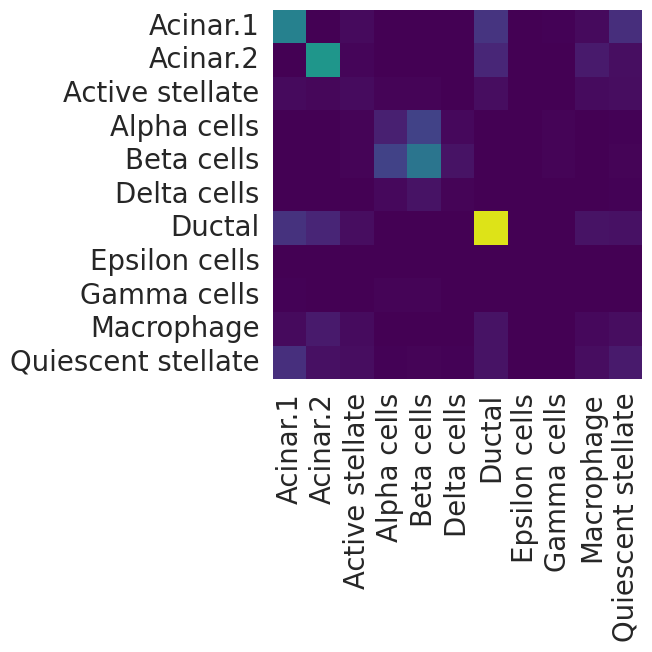

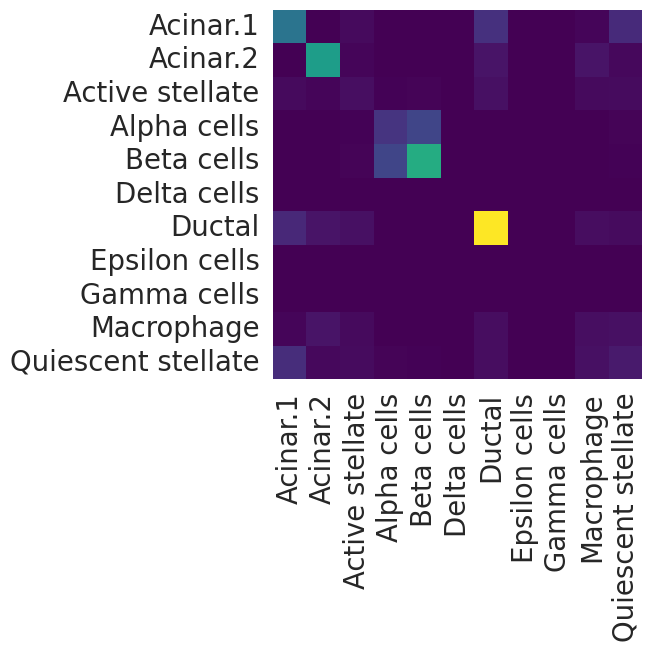

In [18]:
import seaborn as sns

sns.set(font_scale=1.8)
sns.heatmap(mmcci.it.calculate_overall_interactions(all_filtered).apply(np.log1p), cmap='viridis', cbar=False, square=True, vmin=0, vmax=0.2)
plt.show()
sns.heatmap(mmcci.it.calculate_overall_interactions(integrated_any_sum_filtered).apply(np.log1p), cmap='viridis', cbar=False, square=True, vmin=0, vmax=0.2)
plt.show()
sns.set(font_scale=1)

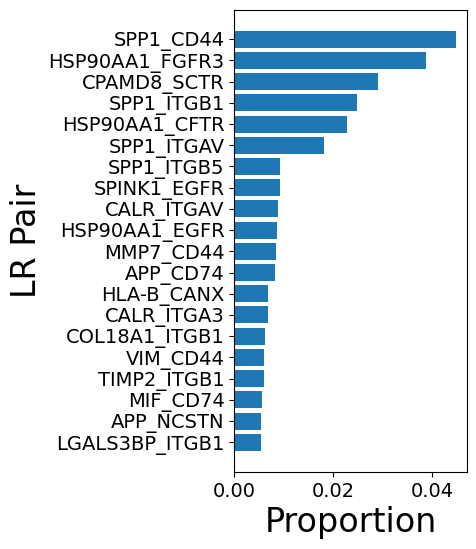

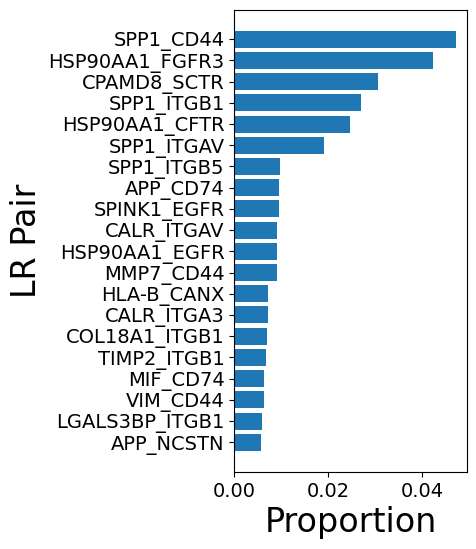

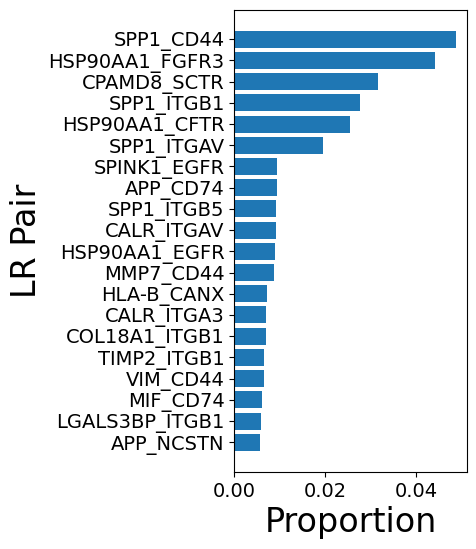

In [19]:
mmcci.plt.lrs_per_celltype(all_filtered, "Ductal", "Ductal", n=20, y_tick_size=14, figsize=(3,6))
mmcci.plt.lrs_per_celltype(integrated_any_sum_filtered, "Ductal", "Ductal", n=20, y_tick_size=14, figsize=(3,6))
mmcci.plt.lrs_per_celltype(integrated_any_filtered, "Ductal", "Ductal", n=20, y_tick_size=14, figsize=(3,6))

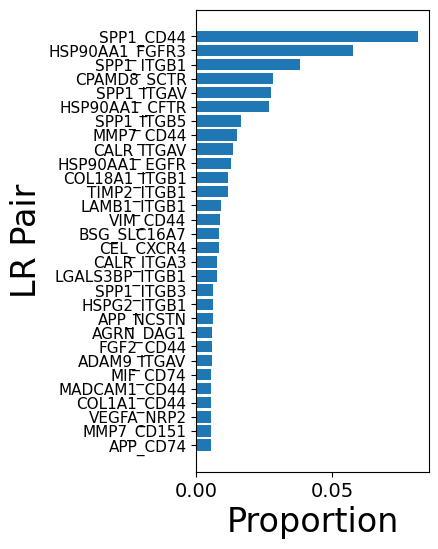

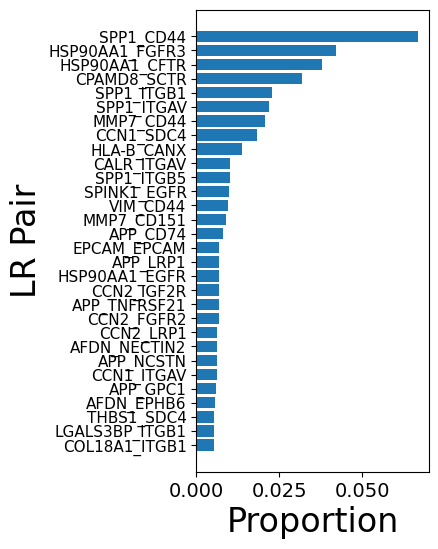

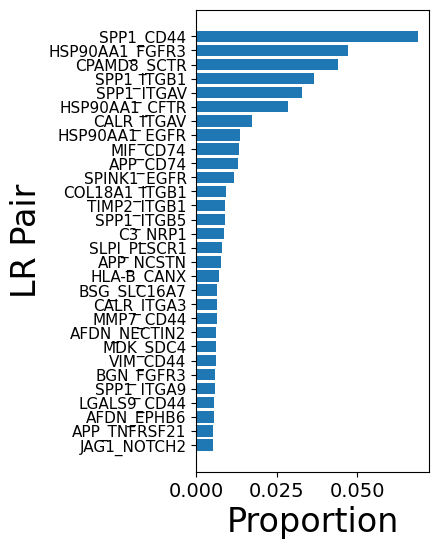

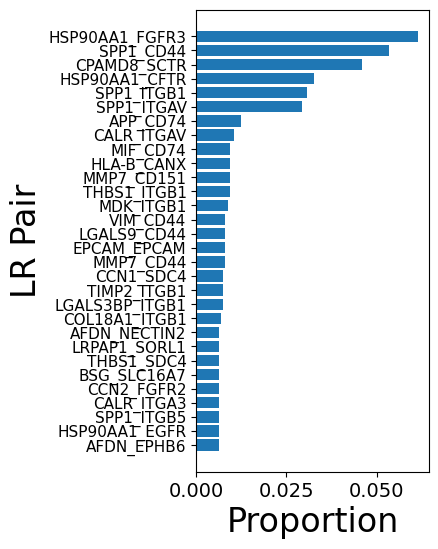

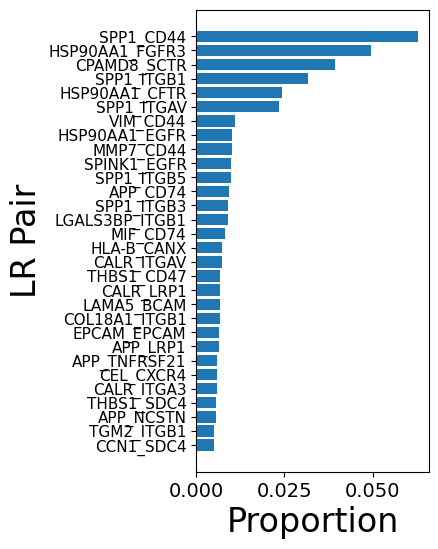

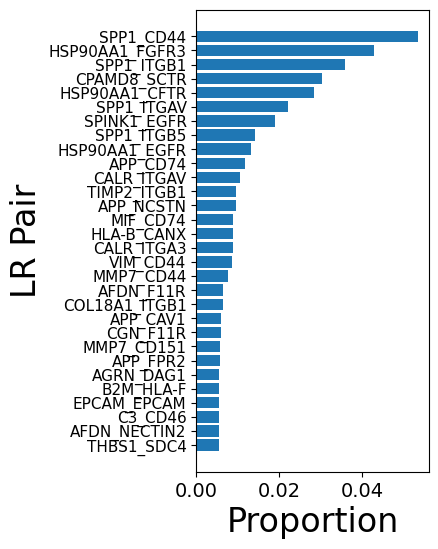

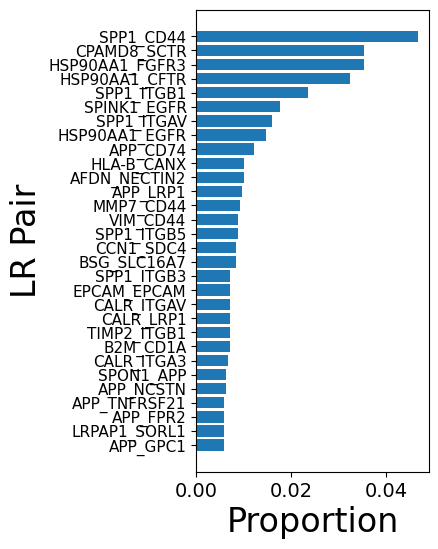

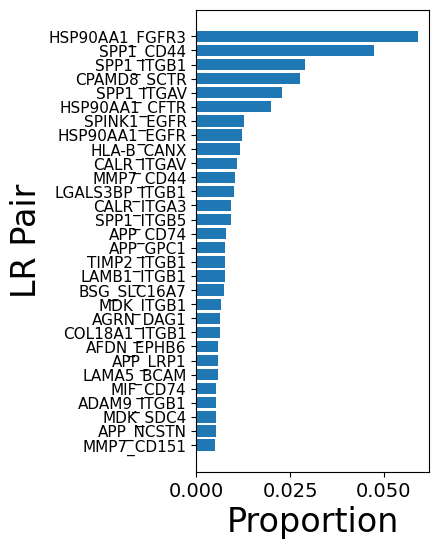

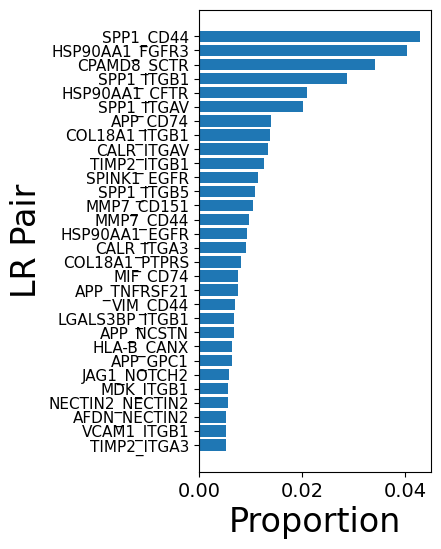

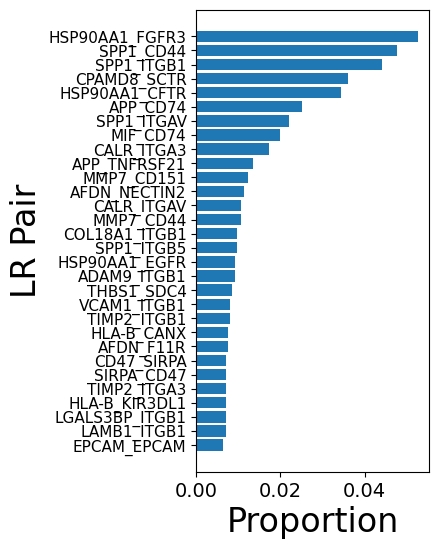

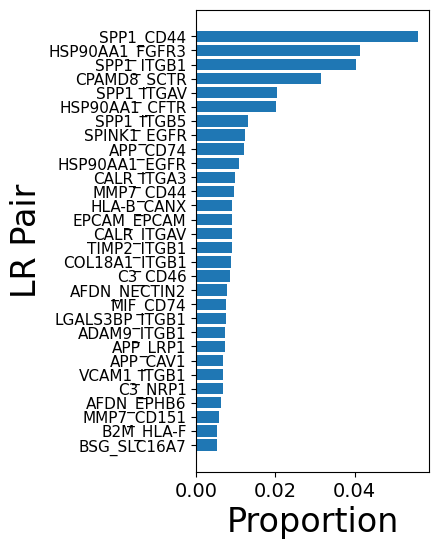

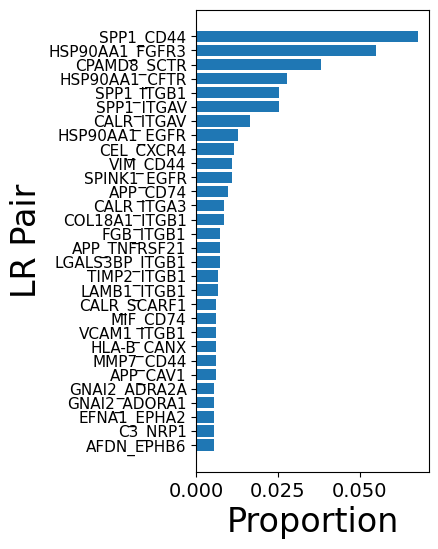

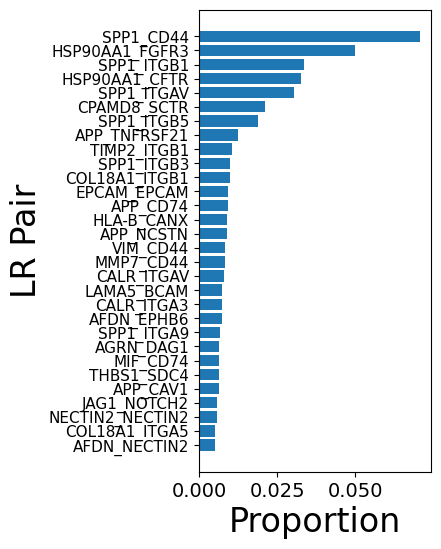

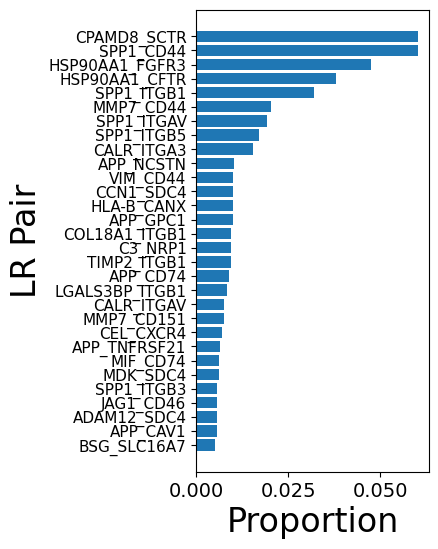

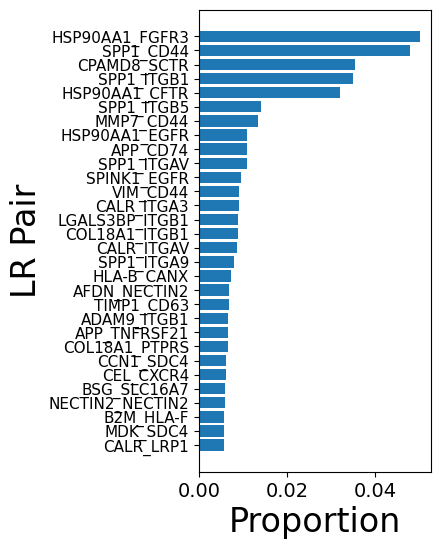

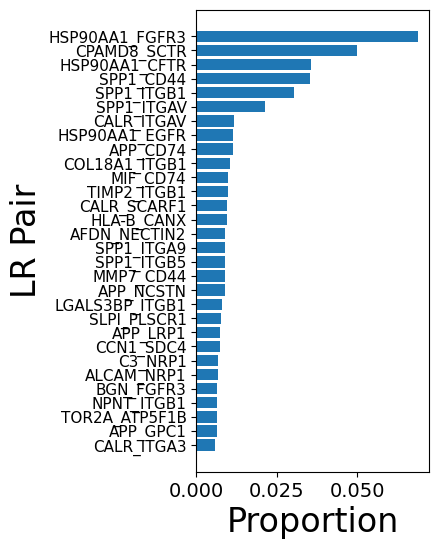

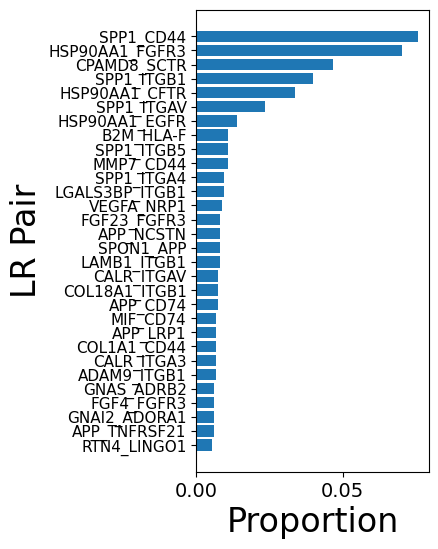

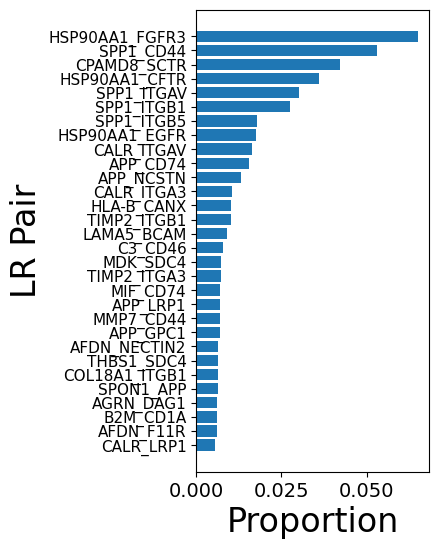

In [20]:
fov_counts = {}

for sample in rest_filtered:
    mmcci.plt.lrs_per_celltype(sample, "Ductal", "Ductal", n=30, y_tick_size=11, figsize=(3,6))
    for lr in mmcci.an.get_lrs_per_celltype(sample, "Ductal", "Ductal"):
        if lr in fov_counts:
            fov_counts[lr] += 1
        else:
            fov_counts[lr] = 1

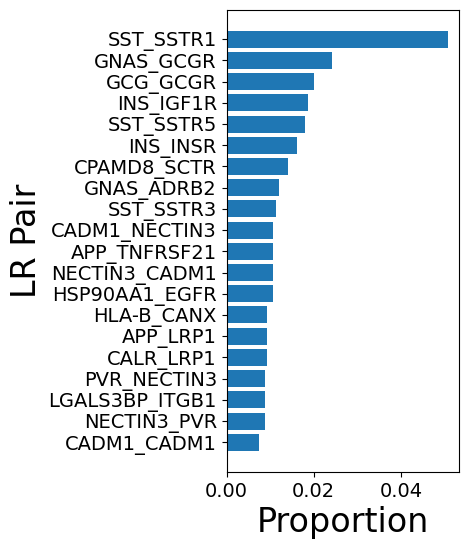

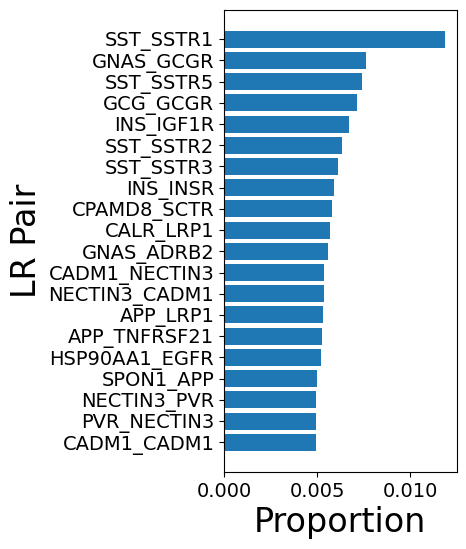

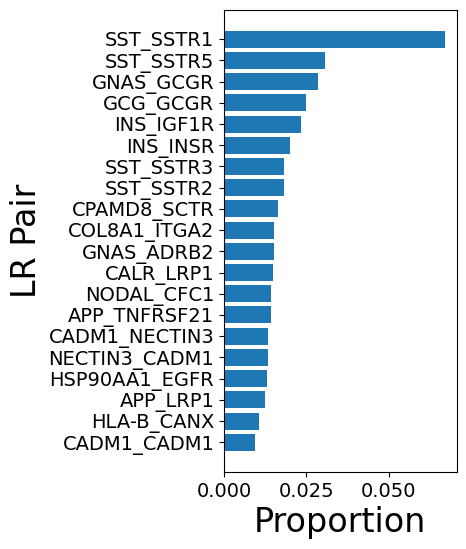

In [21]:
mmcci.plt.lrs_per_celltype(all_filtered, "Delta cells", "Beta cells", n=20, y_tick_size=14, figsize=(3,6))
mmcci.plt.lrs_per_celltype(integrated_any_filtered, "Delta cells", "Beta cells", n=20, y_tick_size=14, figsize=(3,6))
mmcci.plt.lrs_per_celltype(integrated_any_sum_filtered, "Delta cells", "Beta cells", n=20, y_tick_size=14, figsize=(3,6))

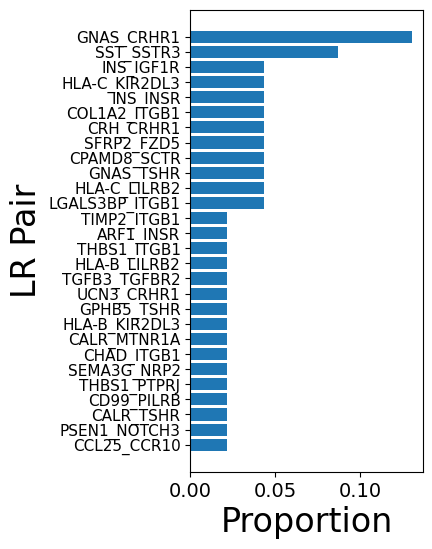

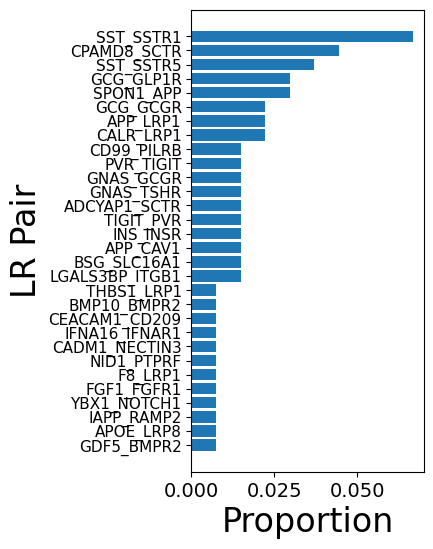

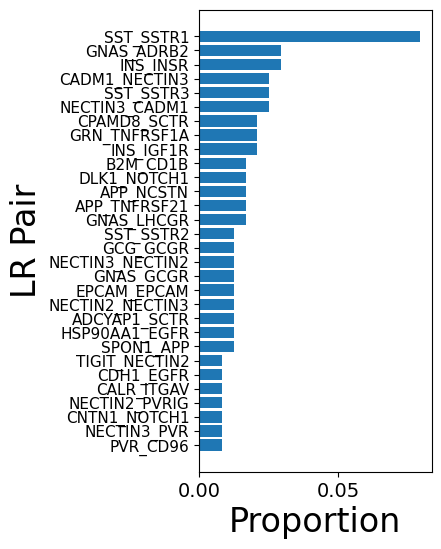

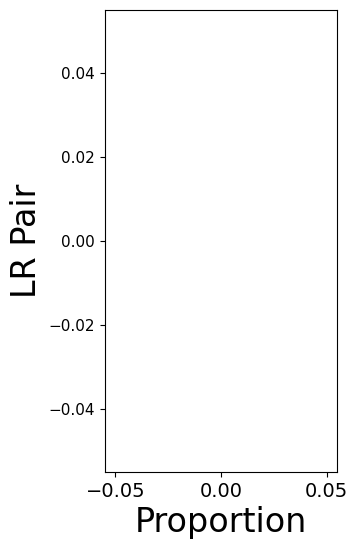

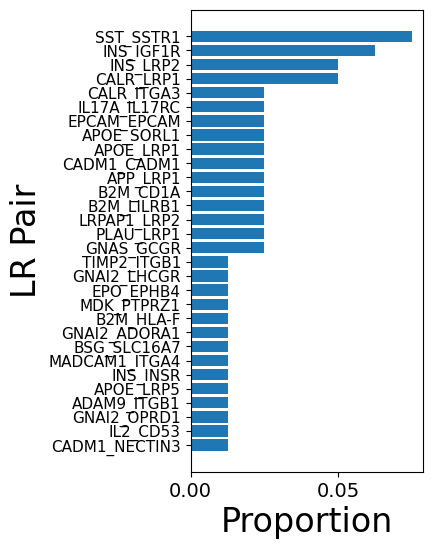

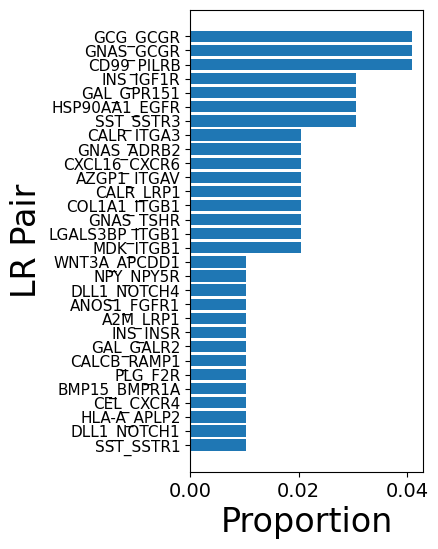

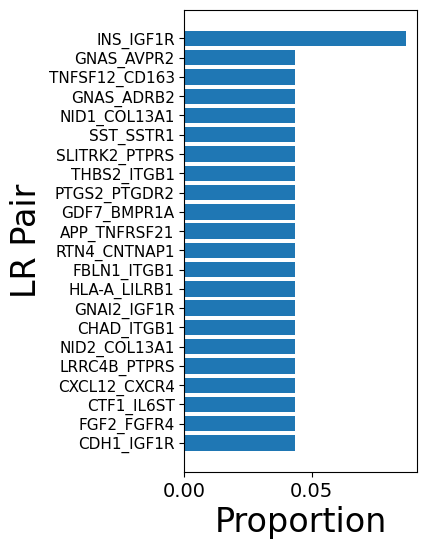

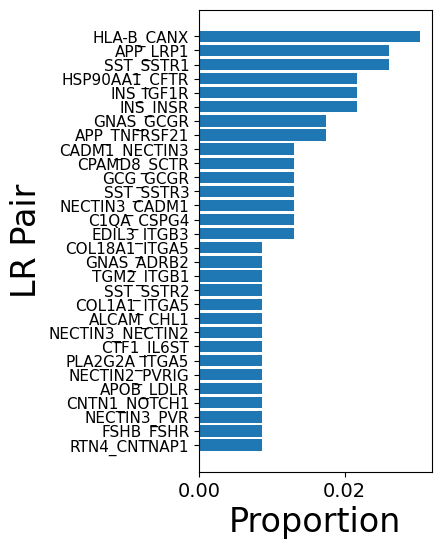

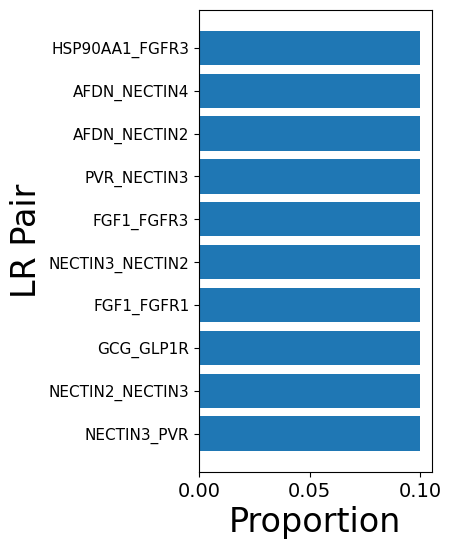

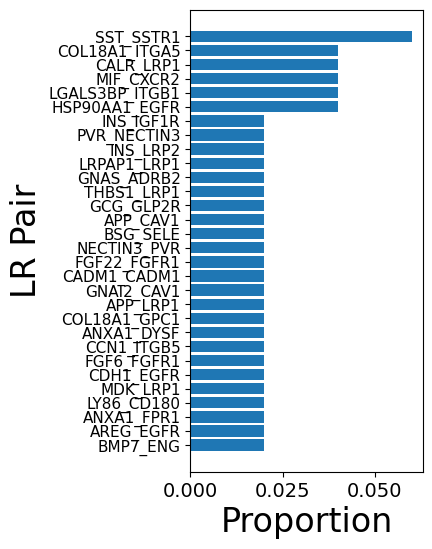

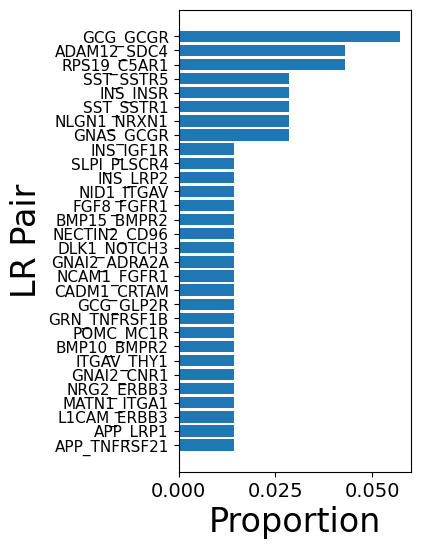

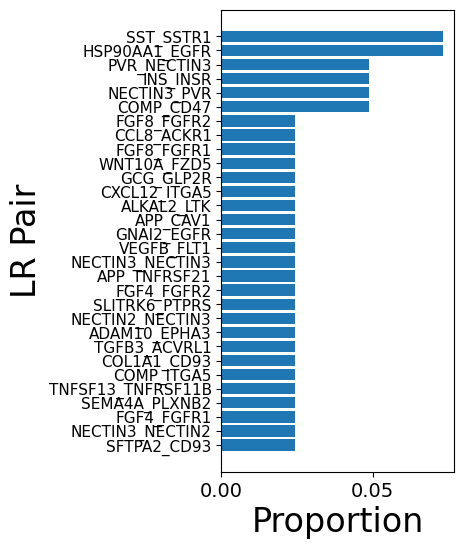

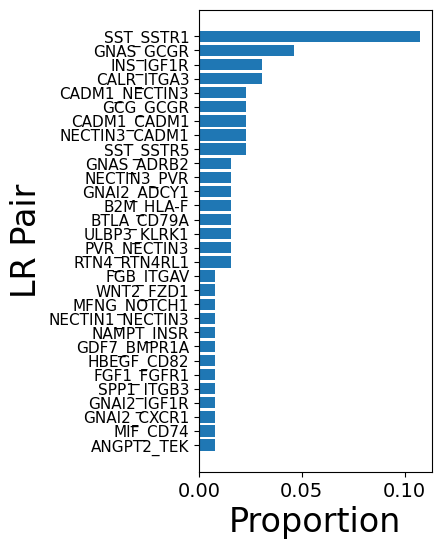

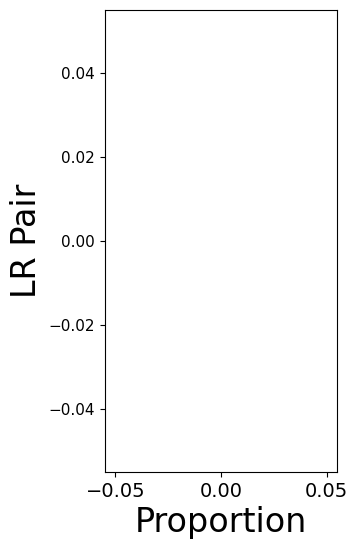

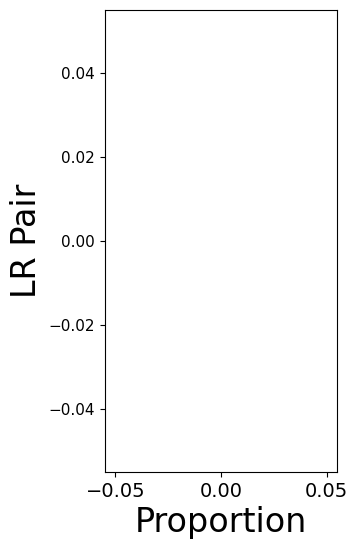

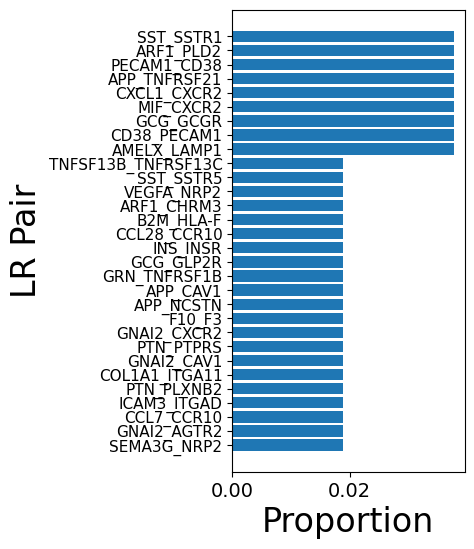

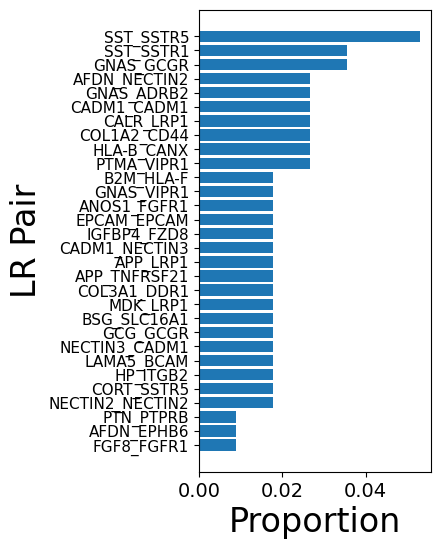

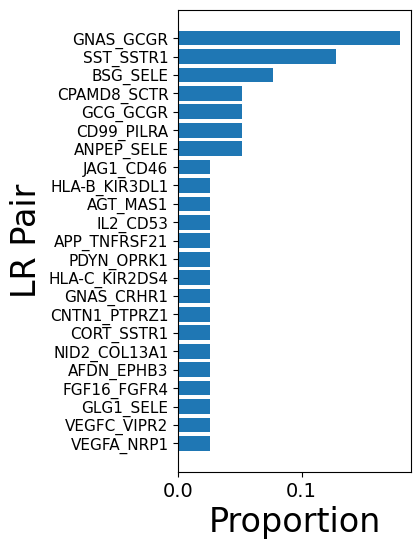

In [22]:
fov_counts = {}

for sample in rest_filtered:
    mmcci.plt.lrs_per_celltype(sample, "Delta cells", "Beta cells", n=30, y_tick_size=11, figsize=(3,6))
    for lr in mmcci.an.get_lrs_per_celltype(sample, "Delta cells", "Beta cells"):
        if lr in fov_counts:
            fov_counts[lr] += 1
        else:
            fov_counts[lr] = 1